In [1]:
import cv2
import imageio
import os
import sys
import caiman as cm
import numpy as np
import scipy as sp
import h5py
import scipy.io as sio
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)

### 1. Load data

In [3]:
from skimage import io
imgStack = io.imread('/Volumes/ahrenslab/Takashi/toZiqiang/10192017Fish3-1/partial.tif')

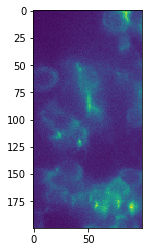

In [4]:
plt.imshow(imgStack[0,100:300,50:150])

### 1.1 Crop time series data, ranged as x, y, t

In [5]:
Frame = imgStack[:, 100:300,50:150]
Y = np.asarray(Frame)
Y = Y.transpose([1,2,0])

### 2. Detrend raw signal

In [16]:
from spatialDenoising.trefide import detrend
from spatialDenoising.tools import remove_trend

In [17]:
dims = Y.shape
Y_rm = Y.reshape((np.prod(dims[:2]),dims[2]),order='F')
Y_det, offset = remove_trend(Y_rm)

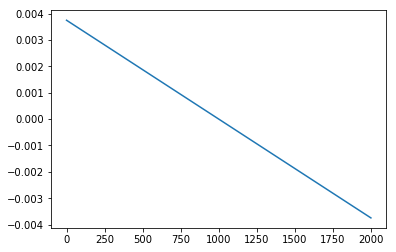

In [19]:
n_pixel = 900
plt.plot(offset[n_pixel, :])
plt.show()

### Spatial smooth over a boxed neighbour with half length gHalf

In [9]:
from spatialDenoising.spatial_filtering import spatial_filter_image

In [20]:
#Y_detr = Y_det.reshape((dims[0],dims[1])+(dims[2],),order='F')
Y_detr = Y.copy()
##offset = offset.reshape((dims[0],dims[1])+(dims[2],),order='F')

In [11]:
# neighbors
k = 4
gHalf = np.array([k,k]) // 2

In [22]:
_, Y_wf = spatial_filter_image(Y_detr,gHalf=gHalf)
_, Y_wff = spatial_filter_image(Y_wf,gHalf=gHalf)
_, Y_wfff = spatial_filter_image(Y_wff,gHalf=gHalf)

first k pixels 0
first k pixels 1000
first k pixels 2000
first k pixels 3000
first k pixels 4000
first k pixels 5000
first k pixels 6000
first k pixels 7000
first k pixels 8000
first k pixels 9000
first k pixels 10000
first k pixels 11000
first k pixels 12000
first k pixels 13000
first k pixels 14000
first k pixels 15000
first k pixels 16000
first k pixels 17000
first k pixels 18000
first k pixels 19000


AttributeError: 'list' object has no attribute 'mean'

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
mean_ = Y_wfff.mean(axis=2,keepdims=True)
sn, psdx =cm.source_extraction.cnmf.pre_processing.get_noise_fft(Y_wfff - mean_,noise_method='logmexp')

In [ ]:
A= Y_wfff.var(2)
B = sn**2
C = A/B

In [ ]:
f, ax = plt.subplots(1, 2)
ax[0].imshow(Y.mean(axis=2))
ax[1].imshow(np.log(C))
plt.show()

In [ ]:
import preprocess_blockSVD as pre_svd

k =50
maxlag = 5
confidence = 0.95 # confidence has to change according to data length

tsub = 1
noise_norm = False
iterate = False 
corr = True
kurto = False
tfilt = False
share_th = True
tfide = False
Yd_detr, ranks = pre_svd.svd_patch(Y_detr,k=k,maxlag=maxlag,tsub=tsub, noise_norm=noise_norm, iterate=iterate,confidence=confidence,corr=corr,kurto=kurto,tfilt = tfilt,tfide=tfide,share_th=share_th)

In [ ]:
plt.imshow(Y_detr[:,:,0])

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.plot(Y_detr[40,60,:])
plt.show()
fig = plt.figure(figsize=(15,5))
plt.plot(Yd_detr[40,61,:])
plt.show()


In [ ]:
#Yd_detr
Yd_wf

In [ ]:
project_dir = '/data/lab/voltageimaging/cosyne1119/'
#fname = 'FOV2_123339_Tread_3_speed_Dilas_truncated.mat'
fname = '06152017Fish1-2_registered-partial_truncated.mat'
f_out=project_dir+fname[:-4]+'_outs.mat'

In [ ]:
f_out

In [ ]:
Yd_wf.shape

In [ ]:
sio.savemat(f_out,{'Y':Y_detr, 
                   'Yd_detr':Yd_detr,
                    'Y_wf':Y_wf,
                   'Yd_wf':Yd_wf,
                   'truncate':'Y[100:6100,100:200,120:280]'})
                   #'truncate':'Y[100:5100,1:-5,10:-18]'})

In [ ]:
'Y':Y,  # Yraw
'offset':offset, #slow trend
'Y_detr':Y_detr, # Y - offset 
'Yd_detr':Yd_detr, # Y_detr denoised PCA
'Yd_detrt':Yd_detrt,# Y_detr denoised PCA + L1T
'Y_wf':Y_wf, # Y_detr denoised spatially WF
'Yd_wf':Yd_wf, # Yd_wf (Y_detr denoised spatially WF) then denoised PCA
'Yd_wft':Yd_wft} # Yd_wf (Y_detr denoised spatially WF) then denoised PCA + L1T **

In [ ]:
M1 = cm.movie(Y_detr[:,:,500:]).transpose([2,0,1])
M2 = cm.movie(Yd_detr[:,:,500:]).transpose([2,0,1])

M3 = M1 - M2

if False:
    M1 = M1 - M1.min()+1
    M2 = M2 - M2.min()+1
    M3 = M3 - M3.min()+1

if True:
    M1 = M1 - M1.min(0,keepdims=True)
    M2 = M2 - M2.min(0,keepdims=True)
    M3 = M3 - M3.min(0,keepdims=True)

if True: #own scale
    movies = [M1,M2,M3]
    max_vals =list(map(np.max,movies))
    max_all = np.max(max_vals).astype('float')
    M1 = M1*max_all/max_vals[0]
    M2 = M2*max_all/max_vals[1]
    M3 = M3*max_all/max_vals[2]

cm.concatenate([M1,M2,M3],axis=1)[:,:,:].play(gain=10, fr=100, magnification=5)

In [ ]:
#Yd_detrt = Y_detr denoised tfide=True
#Yd_detr = Y_detr denoised tfide=False

In [ ]:
#Yd_wf = Y_wf denoised tfide=False
Yd_wft = Y_wf denoised tfide=True

In [ ]:
np.array_equiv(Y - offset,Y_detr)

In [ ]:
project_dir = '/data/lab/voltageimaging/cosyne1117/'
fname = 'IntrinsicExcitability_movie017_truncated.mat'
f_out=project_dir+fname[:-4]+'_outs.mat'

In [ ]:
offset = sio.loadmat(f_out)['offset']
Y = sio.loadmat(f_out)['Y']
Y_detr = sio.loadmat(f_out)['Y_detr']
Yd_wft = sio.loadmat(f_out)['Yd_wft']

In [ ]:
plt.imshow(cm.local_correlations(Yd_detr[:,:,:]))

In [ ]:
sio.savemat(f_out,{'Y':Y, 
                   'offset':offset,
                   'Y_detr':Y_detr,
                   'Yd_detr':Yd_detr,
                   'Yd_detrt':Yd_detrt,
                    'Y_wf':Y_wf,
                   'Yd_wf':Yd_wf,
                   'Yd_wft':Yd_wft,
                   'truncate':'Y[5:-5,595:-5,2100:3000]'})

In [ ]:
plt.imshow(cm.local_correlations(Yd_wft[:,:,:500]))

In [ ]:
'Y':Y,  # Yraw
'offset':offset, #slow trend
'Y_detr':Y_detr, # Y - offset 
'Yd_detr':Yd_detr, # Y_detr denoised PCA
'Yd_detrt':Yd_detrt,# Y_detr denoised PCA + L1T
'Y_wf':Y_wf, # Y_detr denoised spatially WF
'Yd_wf':Yd_wf, # Yd_wf (Y_detr denoised spatially WF) then denoised PCA
'Yd_wft':Yd_wft} # Yd_wf (Y_detr denoised spatially WF) then denoised PCA + L1T **

In [ ]:
# Y_wf wiener filter Y_detr
M1 = cm.movie(Y[:,:,500:]).transpose([2,0,1])
M2 = cm.movie(Yd_wft[:,:,500:]+offset[:,:,500:]).transpose([2,0,1])

M3 = M1 - M2

if False:
    M1 = M1 - M1.min()+1
    M2 = M2 - M2.min()+1
    M3 = M3 - M3.min()+1

if False:
    M1 = M1 - M1.min(0,keepdims=True)
    M2 = M2 - M2.min(0,keepdims=True)
    M3 = M3 - M3.min(0,keepdims=True)

if True: #own scale
    movies = [M1,M2,M3]
    max_vals =list(map(np.max,movies))
    max_all = np.max(max_vals).astype('float')
    M1 = M1*max_all/max_vals[0]
    M2 = M2*max_all/max_vals[1]
    M3 = M3*max_all/max_vals[2]

cm.concatenate([M1,M2,M3],axis=1)[:,:,:].play(gain=1, fr=100, magnification=5)

In [ ]:
M1 = cm.movie(Yd_detr[:,:,500:]).transpose([2,0,1])
M2 = cm.movie(Yd_detrt[:,:,500:]).transpose([2,0,1])
M3 = cm.movie(Yd_wf[:,:,500:]).transpose([2,0,1])

M4 = M1 - M2
M5 = M1 - M3

if False:
    M1 = M1 - M1.min()+1
    M2 = M2 - M2.min()+1
    M3 = M3 - M3.min()+1

if True:
    M1 = M1 - M1.min(0,keepdims=True)
    M2 = M2 - M2.min(0,keepdims=True)
    M3 = M3 - M3.min(0,keepdims=True)
    M4 = M4 - M4.min(0,keepdims=True)
    M5 = M4 - M5.min(0,keepdims=True)

if True: #own scale
    movies = [M1,M2,M3,M4,M5]
    max_vals =list(map(np.max,movies))
    max_all = np.max(max_vals)
    M1 = M1*max_all/max_vals[0]
    M2 = M2*max_all/max_vals[1]
    M3 = M3*max_all/max_vals[2]
    M4 = M4*max_all/max_vals[3]
    M5 = M5*max_all/max_vals[4]

Frame1 = cm.concatenate([M1,M2,M4],axis=2)
Frame2 = cm.concatenate([M1,M3,M5],axis=2)
    
cm.concatenate([Frame1,Frame2],axis=1)[:,:,:].play(gain=10, fr=50, magnification=5)

In [ ]:
import trefide as tfd
import preprocess_blockSVD as pre_svd

def trial_one(Y_):
    def process_patch(data_in):
        dims = data_in.shape
        data_all = data_in.reshape((dims[0]*dims[1],dims[2]), order='F').T
        # in a 2d matrix, we get rid of any broke (nan) pixels
        # we assume fixed broken across time
        broken_idx = np.isinf(data_all[0,:])
        data = data_all[:, ~broken_idx]
        # Remove the data mean
        mu = data.mean(0, keepdims=True)
        data0 = data - mu
        U, s, Vt = pre_svd.compute_svd(data0.T, method='vanilla')
        ctid = pre_svd.choose_rank(Vt, maxlag=maxlag,iterate=iterate, confidence=confidence,corr=corr,kurto=kurto)
        n, L = Vt.shape
        vtid = np.zeros(shape=(3, n)) * np.nan
        mean_th = pre_svd.covCI_wnoise(L,confidence=confidence,maxlag=maxlag)
        #keep1 = pre_svd.cov_one(Vt, mean_th, maxlag=maxlag, iterate=iterate)
        ht_data=np.random.randn(L)
        covdata = pre_svd.axcov(ht_data, maxlag)[maxlag:]/ht_data.var()
        keep1 = np.where(np.logical_or(ctid[0, :] == 1, ctid[1, :] == 1))[0]
        #pre_svd.plot_vt_cov(Vt,keep1,maxlag)
        S = np.eye(len(keep1))*s[keep1.astype(int)]
        Yd_patch = U[:,keep1].dot(S.dot(Vt[keep1,:])) + mu.T
        Yd_patch =Yd_patch.reshape((dims[0],dims[1])+(dims[2],),order='F')
        Vt_hat = tfd.denoise(Vt[keep1,:],noise_estimator='fft',noise_method='logmexp')
        Yd_patch_filt = U[:,keep1].dot(S.dot(Vt_hat)) + mu.T
        Yd_patch_filt = Yd_patch_filt.reshape((dims[0],dims[1])+(dims[2],),order='F')
        return S.dot(Vt[keep1,:]),S.dot(Vt_hat) 
    patches = pre_svd.split_image_into_blocks(Y_,k)
    #return process_patch(data_in)
    dimsMc = list(map(np.shape,patches))
    Vt1,Vt1d=[],[]
    shapes=[]
    for patch in patches:
        V1,V1d= process_patch(patch)
        Vt1.append(V1)
        Vt1d.append(V1d)
        shapes.append(V1.shape[0])
    return Vt1,Vt1d,shapes
#patches=pre_svd.split_image_into_blocks(Y_detr,k)
#data_in = patches[6]

In [ ]:
k =50
maxlag = 2
confidence = 0.95 # confidence has to change according to data length

tsub = 1
noise_norm = False
iterate = False 
corr = True
kurto = False
tfilt = False
share_th = True
tfide = True
Vt1,Vt1d,shapes=data_out = trial_one(Y_detr)

In [ ]:
Vts_all = np.concatenate(Vt1)
Vtds_all = np.concatenate(Vt1d)

In [ ]:
num = []
num2 =[]
for ii,shape in enumerate(shapes):
    for n in np.arange(shape):
        num2.append(n)
        num.append(ii)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

Vt = Vts_all#Vts[0]
Vts = Vtds_all#Vt1ds[0]
Vdiff = Vt-Vts

num_components, num_timeframes= Vt.shape


tts = np.arange(num_timeframes)

fig, ax = plt.subplots(2,1,figsize=(15,10))

ymax = Vt.max()
ymin = Vt.min()

ydmax = Vdiff.max()
ydmin = Vdiff.min()

ax[0].set_ylim(ymin,ymax)
ax[1].set_ylim(ydmin,ydmax)
#ax[0].set_title('Vt')
#ax[1].set_title('Residual')
l1,l2,l3=[],[],[]

l1, = ax[0].plot(tts,Vt[0,:],'b')
l2, = ax[0].plot(tts,Vts[0,:],'r')
l3, = ax[1].plot(tts,Vdiff[0,:],'r')

ax[1].legend('line')

def animate(ii):
    l1.set_ydata(Vt[ii,:]) 
    l2.set_ydata(Vts[ii,:]) # update the data
    l3.set_ydata(Vdiff[ii,:]) 
    l3.set_label('Tile %d sv: %d'%(num[ii], num2[ii]))
    ax[1].legend()
    return l1,l2,l3


# Init only required for blitting to give a clean slate.
def init():
    l1.set_ydata(Vt[0,:])
    l2.set_ydata(Vts[0,:])
    l3.set_ydata(Vdiff[0,:])
    l1.set_label('line init')
    ax[1].legend()
    return l1,l2,l3


anim = animation.FuncAnimation(fig, animate, frames=np.arange(num_components-1), init_func=init,blit=False,interval=1000)
#                              interval=500, blit=False
#anim.save('traces.mp4',fps=5,extra_args=['-vcodec','libx264'])

HTML(anim.to_html5_video())

In [ ]:
anim.save('traces_Vt_Vtd_nostim.mp4',fps=5,extra_args=['-vcodec','libx264'])